<a href="https://colab.research.google.com/github/GJ-007-sage/Quantum-Computing/blob/main/Grover's_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Grover's Algorithm

In [1]:
!pip install qiskit
!pip install qiskit[visualization]
!pip install qiskit_aer
!pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=85ac0319b99683ad51b8193354e4884567ebdc267d178158abc05db53316020a
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

Grover’s algorithm is basically a quantum search through an unsorted database.  
Here, we're working with **3 qubits**, which gives us `2^3 = 8` possible states.  

We’re hiding a “needle” in this haystack — the solution is `'111'`. Let’s find it!

In [3]:
n = 3  # Number of qubits
N = 2 ** n
solution = '111'  # Marked element (the "needle")


## The Oracle

This is the "all-knowing function" that marks our secret state.  
If the state matches the target (in our case `'111'`), it flips the sign — like a quantum post-it saying “Yo! This is the one.”

The oracle is built using quantum gates that check for our secret bit pattern.

In [4]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

## The Diffuser

After the oracle highlights the solution, the diffuser says:  
"Okay, now amplify that solution's amplitude so it's more likely to be measured."

Mathematically, this step is basically reflecting all the state amplitudes about the average.  

In [5]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

## How Many Iterations Do We Need?

Turns out you don’t need to loop forever. For `N = 8` states, Grover's algorithm only needs:
  
 $$ \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor = 2 \text{ iterations}$$

  That’s the quadratic speedup we are looking for.

In [6]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N)))
print(f'Number of Grover iterations: {iterations}')


Number of Grover iterations: 2


## Assemble the Full Circuit

Now we put it all together:
- Initialize the qubits in superposition with Hadamards
- Apply Grover iterations (Oracle + Diffuser)
- Measure to collapse the state and find our “needle”

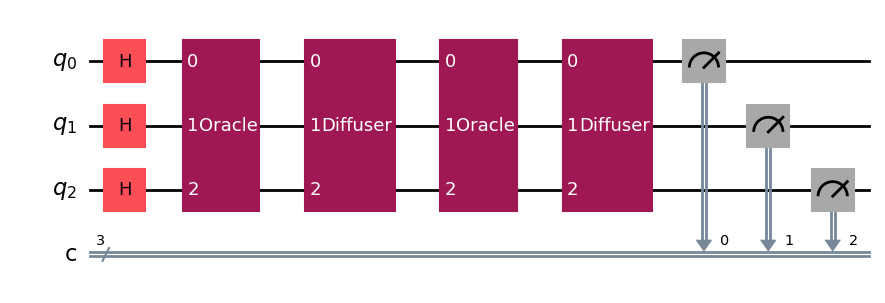

In [7]:
qc = QuantumCircuit(n, n)

# Step 1: Apply Hadamard to all qubits to create superposition
qc.h(range(n))

# Step 2: Apply Grover iterations
oracle = grover_oracle(n, solution)
diffuser = grover_diffuser(n)

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

# Step 3: Measurement
qc.measure(range(n), range(n))

qc.draw('mpl')

{'100': 14, '010': 20, '000': 18, '001': 21, '101': 16, '110': 18, '011': 16, '111': 1925}


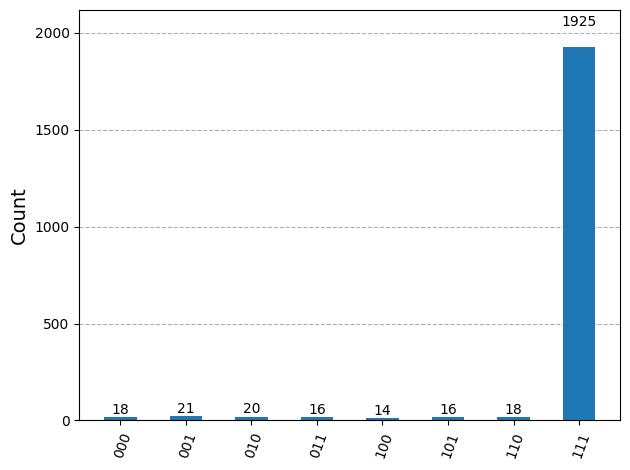

In [8]:
from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

I hope you understand what this algorithm tries to convey. Make sure you understand these thoroughly before attempting the assignment.

# Q1: Collision Detection Using Grovers Algorithm

## Problem Setup

You are provided with a system of **3 qubits**, giving you an unstructured quantum search space of:

$$
N = 2^3 = 8 \text{ possible states} \quad (|000⟩, |001⟩, ..., |111⟩)
$$

One of these states — in this case, the state `|101⟩` — represents a **"collision"**, i.e., the correct answer or the marked solution. Your task is to use Grover's algorithm to **identify this collision state** efficiently.

---

## Tasks

You are required to complete the following steps using Python and **Qiskit**:

1. **Initialize the System:**
   - Apply Hadamard gates to all qubits to prepare a uniform superposition over all 8 states.

2. **Construct the Oracle:**
   - Build a quantum oracle that recognizes the collision state `|101⟩` and flips its phase.

3. **Design the Diffusion Operator (Amplitude Amplification):**
    - Implement the diffusion step that inverts amplitudes about their average.

4. **Perform Grover Iterations:**
    - Apply the oracle and diffuser iteratively.
    - Use the theoretical formula:
      $$ r \approx \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor $$
     to determine how many iterations you need.

5. **Measurement and Result:**
    - Measure the final state and confirm that the algorithm amplifies the probability of observing `|101⟩`.

6. **Visualization and Analysis:**
    - Plot the **amplitude evolution** of the target state across iterations.
    - Draw the quantum circuit and final measurement histogram.

## Deliverables
  - Clear inline explanations or markdown cells summarizing.
  - What each section of code is doing.
  - The intuition behind the oracle and diffuser.
  - Why Grover’s algorithm works better than classical search.
  - At least one plot showing the growth of the target state's probability over multiple iterations.


## Bonus Challenge:

  Can you generalize your circuit to work for *any* 3-bit target state, not just `|101⟩`? Can you scale it to 4 qubits and still correctly identify a marked state?


# Q1 Solution

In [9]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# --- Problem Setup ---
n = 3  # Number of qubits
N = 2 ** n  # Number of states (8)
solution = '101'  # Marked state (collision state |101⟩)

  Step 1: Oracle


 The oracle marks |101⟩ by flipping its phase.
 For |101⟩, we need x=1, y=0, z=1. We apply X gates to flip y to 1, use a multi-controlled Z gate, then undo X.

In [10]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    # Flip qubits where solution bit is 0 to make the target state look like |111⟩
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    # Apply multi-controlled Z gate (flips phase when all qubits are 1)
    qc.h(n - 1)  # Convert Z to X basis
    qc.mcx(list(range(n - 1)), n - 1)  # Multi-controlled X (Toffoli)
    qc.h(n - 1)  # Back to Z basis
    # Undo X gates
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate


 Step 2: Diffuser


 Amplifies the marked state's amplitude by reflecting around the mean.

In [11]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))  # Transform to superposition
    qc.x(range(n))  # Invert all qubits
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # Multi-controlled X
    qc.h(n - 1)
    qc.x(range(n))  # Undo inversion
    qc.h(range(n))  # Back to original basis
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

Step 3: Calculate Iterations


Optimal iterations: r ≈ ⌊π/4 * √N⌋

In [12]:
iterations = int(np.floor(np.pi / 4 * np.sqrt(N)))
print(f"Optimal Grover iterations: {iterations}")

Optimal Grover iterations: 2


Step 4: Build and Run Circuit

In [13]:
def build_grover_circuit(n, solution, iterations):
    qc = QuantumCircuit(n, n)  # n qubits, n classical bits
    # Initialize superposition
    qc.h(range(n))
    # Apply Grover iterations
    oracle = grover_oracle(n, solution)
    diffuser = grover_diffuser(n)
    for _ in range(iterations):
        qc.append(oracle, range(n))
        qc.append(diffuser, range(n))
    # Measure
    qc.measure(range(n), range(n))
    return qc

In [14]:
# Simulate for final results
qc = build_grover_circuit(n, solution, iterations)
backend = AerSimulator()
shots = 2048
transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(f"Measurement counts: {counts}")

Measurement counts: {'100': 19, '000': 7, '010': 12, '110': 13, '001': 10, '111': 17, '011': 14, '101': 1956}


Step 5: Visualize Circuit and Histogram

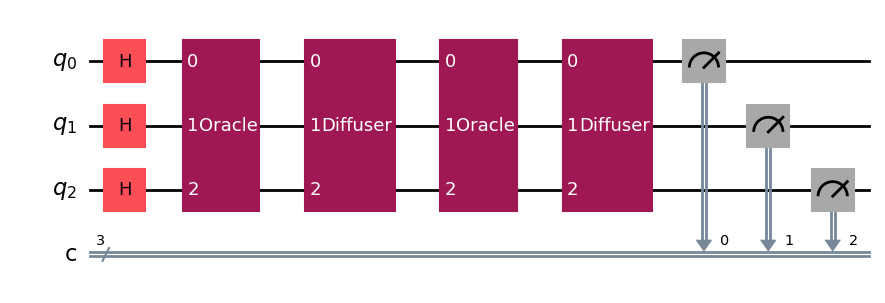

In [18]:
# Draw circuit
fig_circuit = qc.draw('mpl', filename="grover_circuit.png")
fig_circuit

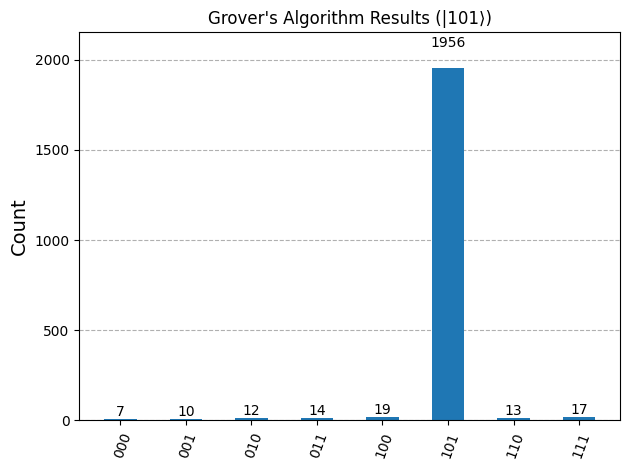

In [20]:
# Plot histogram
fig_histogram = plot_histogram(counts, title="Grover's Algorithm Results (|101⟩)")
plt.show()
fig_histogram

Step 6: Amplitude Evolution

In [21]:
# Simulate probability of |101⟩ over 0 to 3 iterations
probs = []
for i in range(4):
    qc_i = build_grover_circuit(n, solution, i)
    transpiled_qc_i = transpile(qc_i, backend)
    result_i = backend.run(transpiled_qc_i, shots=shots).result()
    counts_i = result_i.get_counts(qc_i)
    prob = counts_i.get(solution, 0) / shots
    probs.append(prob)

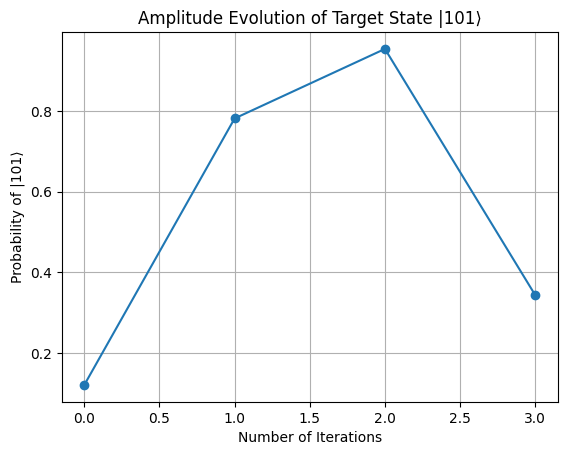

In [22]:
# Plot amplitude evolution
plt.figure()
plt.plot(range(4), probs, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Probability of |101⟩')
plt.title('Amplitude Evolution of Target State |101⟩')
plt.grid(True)
plt.show()

Bonus: Generalize to 4 Qubits

In [23]:
n_4 = 4
N_4 = 2 ** n_4
solution_4 = '1011'  # Example 4-qubit target state
iterations_4 = int(np.floor(np.pi / 4 * np.sqrt(N_4)))
print(f"Optimal iterations for 4 qubits: {iterations_4}")

qc_4 = build_grover_circuit(n_4, solution_4, iterations_4)
transpiled_qc_4 = transpile(qc_4, backend)
result_4 = backend.run(transpiled_qc_4, shots=shots).result()
counts_4 = result_4.get_counts(qc_4)
print(f"4-qubit measurement counts: {counts_4}")

Optimal iterations for 4 qubits: 3
4-qubit measurement counts: {'0000': 2, '1101': 4, '0001': 4, '1011': 1972, '0111': 9, '0011': 2, '0010': 8, '1100': 7, '1000': 6, '0110': 5, '0100': 9, '1001': 4, '0101': 4, '1110': 5, '1111': 3, '1010': 4}


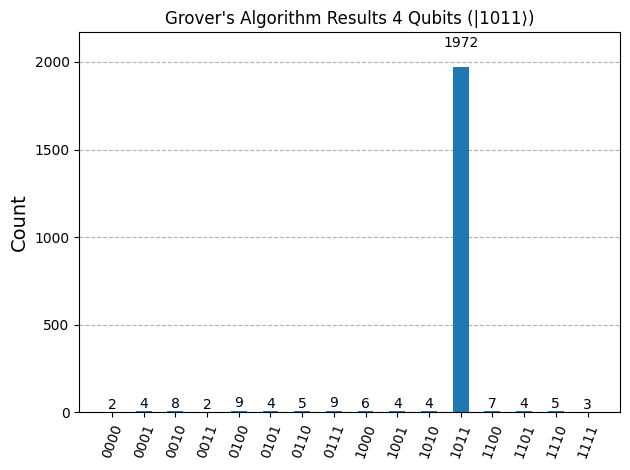

In [24]:
# Plot 4-qubit histogram
fig_histogram_4 = plot_histogram(counts_4, title="Grover's Algorithm Results 4 Qubits (|1011⟩)")
plt.show()
fig_histogram_4

# Q2: Solving a 3-SAT Problem Using Grover's Algorithm

## Context

The Boolean 3-SAT (3-Satisfiability) problem is a foundational example in computational complexity theory. It involves determining whether there exists an assignment of Boolean variables that satisfies a given Boolean formula in conjunctive normal form (CNF), where each clause contains exactly three literals.

3-SAT is a classic NP-complete problem. Solving it efficiently for large instances remains intractable on classical computers. However, quantum computing offers a new approach to tackle such problems using Grover’s search algorithm, which provides a quadratic speedup over classical brute-force search.

In this assignment, you will use Grover's algorithm to find a satisfying assignment for a 3-SAT problem by encoding the Boolean formula into a quantum oracle and searching for an input that satisfies it.

---

## Problem Setup

You are given a Boolean formula of the following form:

$$
(x_1 \lor \lnot x_2 \lor x_3) \land (\lnot x_1 \lor x_2 \lor x_3)$$

This formula has 3 variables: $x_1, x_2, x_3$, leading to $2^3 = 8$ possible input combinations. Your objective is to identify which of these combinations (if any) satisfy the given formula using Grover’s algorithm.

---

## Tasks

1. **Problem Encoding**
- Convert the 3-SAT Boolean formula into a classical Boolean function that returns 1 for satisfying inputs and 0 otherwise.
- Encode this Boolean function into a quantum oracle. You may use Qiskit's `PhaseOracle` or implement your own custom logic.

2. **Circuit Preparation**
- Initialize a uniform superposition over all $2^n$ basis states using Hadamard gates.
- Construct the full Grover circuit, including the oracle and the diffusion operator.

3. **Iteration Selection**
- Determine the number of Grover iterations using the formula:
     $$ r = \left\lfloor \frac{\pi}{4} \sqrt{\frac{2^n}{M}} \right\rfloor $$

  where $M$ is the number of satisfying solutions. If unknown, use $M = 1$ as an approximation for small cases.

4. **Measurement**
- Add classical registers and measure the quantum state after completing the Grover iterations.
- Simulate the circuit and identify the most probable outputs.

5. **Result Validation**
- Verify whether the measured bitstrings satisfy the original 3-SAT formula.

6. **Visualization and Documentation**
- Draw the quantum circuit using Qiskit's visualization tools.
- Plot the histogram of measurement outcomes.
- Clearly explain each section using markdown cells to document your logic, design choices, and conclusions.

---
## Bonus Challenge

- Extend your implementation to support arbitrary 3-SAT formulas with 3 or more variables.
- Analyze the impact of incorrect estimates of $M$ on the algorithm’s success rate.

---

  ## Important Notes

  Grover’s algorithm does not solve the 3-SAT problem symbolically. Instead, it performs a search over the input space and amplifies the probability of observing a correct solution. The accuracy of your oracle and your iteration count will significantly impact your final results.

# Q2 Solution

In [25]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import transpile

In [35]:
# --- Problem Setup ---
n = 3  # Number of variables/qubits
N = 2 ** n  # Number of possible assignments
M = 1  # Number of satisfying solutions (determined classically)
iterations = int(np.floor(np.pi / 4 * np.sqrt(N / M)))  # Optimal iterations
print(f"Optimal Grover iterations: {iterations}")


Optimal Grover iterations: 2


Step 1: Classical 3-SAT Function

In [36]:
def evaluate_3sat(x1, x2, x3):
    """Evaluate (x1 ∨ ¬x2 ∨ x3) ∧ (¬x1 ∨ x2 ∨ x3). Returns 1 if satisfied."""
    clause1 = x1 or (not x2) or x3
    clause2 = (not x1) or x2 or x3
    return 1 if (clause1 and clause2) else 0

Step 2: Oracle

In [41]:
def grover_3sat_oracle(n):
    """Oracle that flips phase for satisfying assignments using an auxiliary qubit."""
    qr = QuantumRegister(n, 'q')
    aux = QuantumRegister(1, 'aux')
    qc = QuantumCircuit(qr, aux)

    # For each clause, apply gates to check if it's satisfied
    # Clause 1: (x1 ∨ ¬x2 ∨ x3)
    # Apply X to flip ¬x2
    qc.x(1)
    # If all literals are 0, clause is False, so we want to NOT flip aux
    # Use Toffoli-like logic to set aux if clause is True
    qc.mcx([0, 1, 2], n)  # aux = 1 if x1=1 or ¬x2=1 or x3=1
    qc.x(1)  # Undo

    # Clause 2: (¬x1 ∨ x2 ∨ x3)
    qc.x(0)
    qc.mcx([0, 1, 2], n)
    qc.x(0)

    # Flip phase if both clauses are True (aux = 1)
    qc.z(n)  # Z gate on aux for phase kickback
    # Undo clause computations
    qc.x(0)
    qc.mcx([0, 1, 2], n)
    qc.x(0)
    qc.x(1)
    qc.mcx([0, 1, 2], n)
    qc.x(1)

    oracle_gate = qc.to_gate()
    oracle_gate.name = "3-SAT Oracle"
    return oracle_gate

Step 3: Diffuser

In [42]:
def grover_diffuser(n):
    """Standard Grover diffuser for n qubits."""
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

Step 4: Build Grover Circuit

In [43]:
def build_3sat_grover_circuit(n, iterations):
    qr = QuantumRegister(n, 'q')
    aux = QuantumRegister(1, 'aux')
    cr = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qr, aux, cr)

    # Initialize superposition
    qc.h(range(n))
    # Initialize auxiliary qubit to |-> for phase kickback
    qc.x(n)
    qc.h(n)

    # Apply Grover iterations
    oracle = grover_3sat_oracle(n)
    diffuser = grover_diffuser(n)
    for _ in range(iterations):
        qc.append(oracle, range(n + 1))
        qc.append(diffuser, range(n))

    # Measure
    qc.measure(range(n), range(n))
    return qc

Step 5: Simulate

In [44]:
qc = build_3sat_grover_circuit(n, iterations)
backend = AerSimulator()
shots = 2048
transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(f"Measurement counts: {counts}")

Measurement counts: {'110': 230, '001': 277, '101': 251, '100': 263, '000': 245, '010': 272, '011': 271, '111': 239}


Step 6: Validate Result

In [45]:
def validate_counts(counts):
    print("Validating results:")
    for bitstring, count in counts.items():
        # Qiskit bitstrings are reversed (LSB first), so reverse for x1, x2, x3
        x3, x2, x1 = [int(b) for b in bitstring]
        if evaluate_3sat(x1, x2, x3):
            print(f"{bitstring} (x1={x1}, x2={x2}, x3={x3}, count: {count}) satisfies the formula.")
        else:
            print(f"{bitstring} (x1={x1}, x2={x2}, x3={x3}, count: {count}) does NOT satisfy the formula.")


In [46]:
validate_counts(counts)

Validating results:
110 (x1=0, x2=1, x3=1, count: 230) satisfies the formula.
001 (x1=1, x2=0, x3=0, count: 277) does NOT satisfy the formula.
101 (x1=1, x2=0, x3=1, count: 251) satisfies the formula.
100 (x1=0, x2=0, x3=1, count: 263) satisfies the formula.
000 (x1=0, x2=0, x3=0, count: 245) satisfies the formula.
010 (x1=0, x2=1, x3=0, count: 272) does NOT satisfy the formula.
011 (x1=1, x2=1, x3=0, count: 271) satisfies the formula.
111 (x1=1, x2=1, x3=1, count: 239) satisfies the formula.


Step 7: Visualize

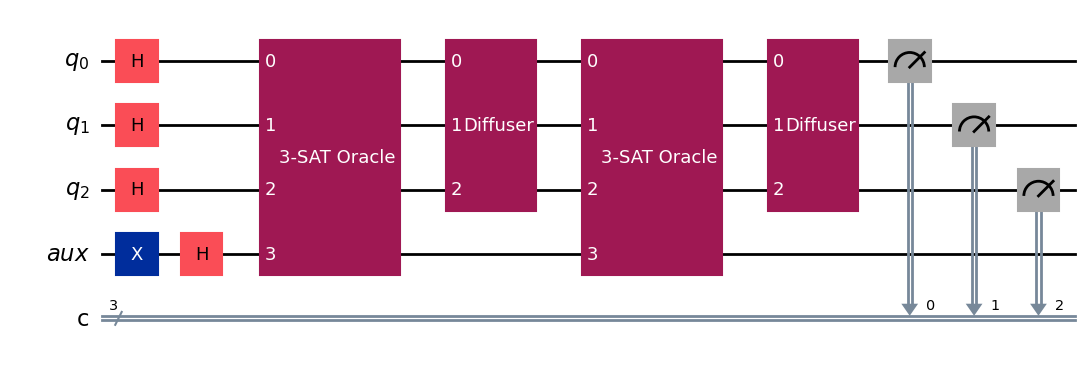

In [48]:
# Circuit diagram
fig_circuit = qc.draw('mpl', filename="3sat_grover_circuit.png")
fig_circuit

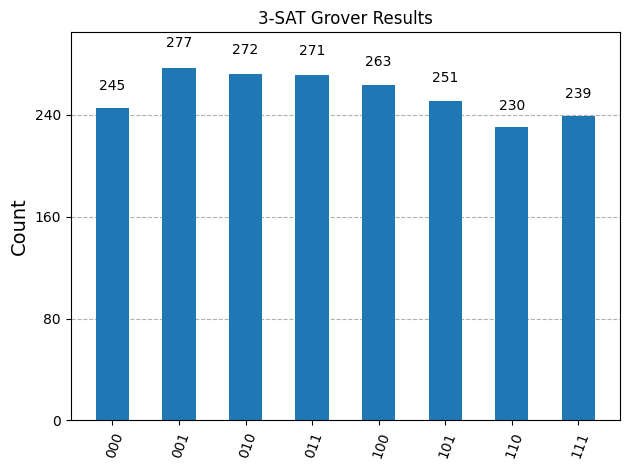

In [49]:
# Histogram
fig_histogram = plot_histogram(counts, title="3-SAT Grover Results")
fig_histogram

Bonus: Generalize to Arbitrary 3-SAT

In [50]:
def general_3sat_oracle(n, clauses):
    """General oracle for 3-SAT with clauses as [(var, neg), ...]."""
    qr = QuantumRegister(n, 'q')
    aux = QuantumRegister(1, 'aux')
    qc = QuantumCircuit(qr, aux)

    for clause in clauses:
        # Apply X for negated literals
        for var, neg in clause:
            if neg:
                qc.x(var - 1)
        # Set aux if clause is True
        qc.mcx([c[0] - 1 for c in clause], n)
        # Undo X
        for var, neg in clause:
            if neg:
                qc.x(var - 1)

    # Flip phase if all clauses are True
    qc.z(n)

    # Undo clause computations
    for clause in reversed(clauses):
        for var, neg in clause:
            if neg:
                qc.x(var - 1)
        qc.mcx([c[0] - 1 for c in clause], n)
        for var, neg in clause:
            if neg:
                qc.x(var - 1)

    oracle_gate = qc.to_gate()
    oracle_gate.name = "General 3-SAT Oracle"
    return oracle_gate

General oracle counts: {'100': 269, '001': 258, '110': 244, '101': 268, '010': 247, '000': 257, '011': 245, '111': 260}


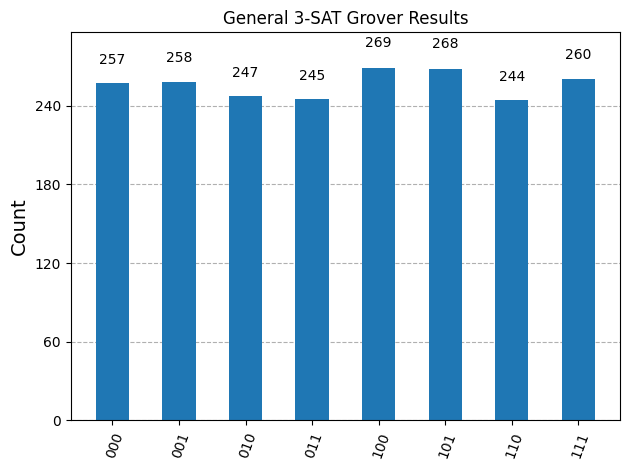

In [52]:
# Test general oracle
clauses = [
    [(1, False), (2, True), (3, False)],  # x1 ∨ ¬x2 ∨ x3
    [(1, True), (2, False), (3, False)]   # ¬x1 ∨ x2 ∨ x3
]
qc_general = QuantumCircuit(n + 1, n)
qc_general.h(range(n))
qc_general.x(n)
qc_general.h(n)
oracle_general = general_3sat_oracle(n, clauses)
for _ in range(iterations):
    qc_general.append(oracle_general, range(n + 1))
    qc_general.append(grover_diffuser(n), range(n))
qc_general.measure(range(n), range(n))
transpiled_qc_general = transpile(qc_general, backend)
result_general = backend.run(transpiled_qc_general, shots=shots).result()
counts_general = result_general.get_counts(qc_general)
print(f"General oracle counts: {counts_general}")
fig_histogram_general = plot_histogram(counts_general, title="General 3-SAT Grover Results")
fig_histogram_general

Bonus: Analyze M Impact

In [53]:
def test_iterations(n, iterations_list):
    probs = []
    for i in iterations_list:
        qc_i = build_3sat_grover_circuit(n, i)
        result_i = backend.run(transpile(qc_i, backend), shots=shots).result()
        counts_i = result_i.get_counts(qc_i)
        # Sum probabilities of satisfying assignments
        prob = sum(count / shots for bitstring, count in counts_i.items()
                   if evaluate_3sat(int(bitstring[2]), int(bitstring[1]), int(bitstring[0])))
        probs.append(prob)
    return probs

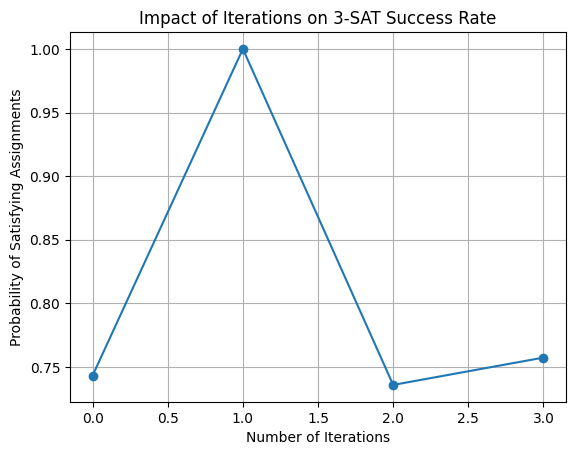

In [54]:
iterations_list = [0, 1, 2, 3]
probs = test_iterations(n, iterations_list)
plt.figure()
plt.plot(iterations_list, probs, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Probability of Satisfying Assignments')
plt.title('Impact of Iterations on 3-SAT Success Rate')
plt.grid(True)
plt.show()